# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest

# Constants

In [2]:
# Data generation
SAMPLE_TRAIN_SIZE = 100
SAMPLE_TEST_SIZE = 5
SAMPLE_OUTLIER_SIZE = 5

# Generalized Deduplication
DEVIATION_BITS = 2

# Load data

In [3]:
rng = np.random.RandomState(42)

# Generate train data
X_train = np.r_[(
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 60, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 50)],
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 50, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100)],
    np.c_[((3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100, (3 * rng.randn(SAMPLE_TRAIN_SIZE, 1)).astype(int) + 100)]
)]

# Generate test data
X_test = np.r_[(
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 60, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50)],
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)],
    np.c_[((3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100, (3 * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)]
)]

# Generate outliers
X_outliers = np.r_[
    (np.c_[(rng.uniform(low=40, high=60, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=70, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))],
     np.c_[(rng.uniform(low=65, high=120, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=60, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))]
     )]
X_outliers = X_outliers.astype(int)

## Plot train, test and outliers in scatter plot

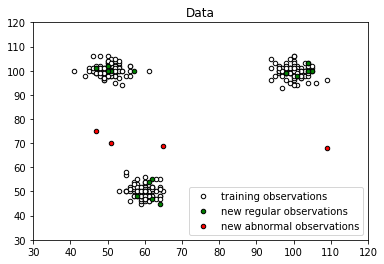

In [4]:
plt.title("Data")
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations", "new regular observations", "new abnormal observations"],
    loc="lower right",
)
plt.show()

## Perform Generalized Deduplication

In [5]:
vectorized_func = np.vectorize(gd.compress_int)

X_train_bases = vectorized_func(X_train, deviation_bits=DEVIATION_BITS, output="integer")

X_test_bases = vectorized_func(X_test, deviation_bits=DEVIATION_BITS, output="integer")

X_outliers_bases = vectorized_func(X_outliers, deviation_bits=DEVIATION_BITS, output="integer")


## Plot train, test and outliers after generalized deduplication in scatter plot

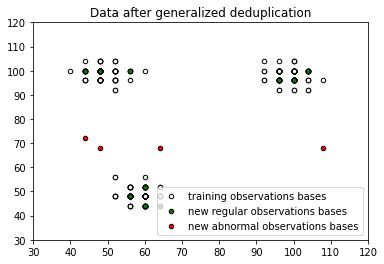

In [6]:
plt.title("Data after generalized deduplication")
b1 = plt.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations bases", "new regular observations bases", "new abnormal observations bases"],
    loc="lower right",
)
plt.show()

<AxesSubplot:ylabel='Density'>

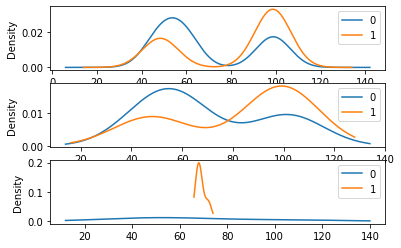

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1)
pd.DataFrame(X_train_bases).plot.density(ax=axes[0])
pd.DataFrame(X_test_bases).plot.density(ax=axes[1])
pd.DataFrame(X_outliers_bases).plot.density(ax=axes[2])

## Isolation Forest

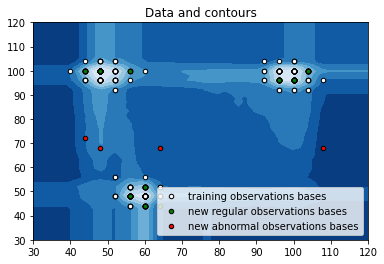

,0
0,-0.041269
1,0.066395
2,0.066395
3,-0.100340
4,0.066395
...,...
295,0.053800
296,0.048833
297,0.053800
298,0.032832


In [16]:
clf = IsolationForest(random_state=rng)
clf.fit(X_train_bases)

y_pred_train = clf.predict(X_train_bases)
y_pred_test = clf.predict(X_test_bases)
y_pred_outliers = clf.predict(X_outliers_bases)

xx, yy = np.meshgrid(np.linspace(30, 120, 50), np.linspace(30, 120, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Data and contours")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((30, 120))
plt.ylim((30, 120))
plt.legend(
    [b1, b2, c],
    ["training observations bases", "new regular observations bases", "new abnormal observations bases"],
    loc="lower right",
)
plt.show()

dec_function = clf.decision_function(X_train_bases)
pd.DataFrame(dec_function)

## Calculations

In [12]:
X_train_bases

array([[ 60,  44],
       [ 60,  48],
       [ 60,  48],
       [ 64,  48],
       [ 60,  48],
       [ 60,  48],
       [ 64,  52],
       [ 60,  48],
       [ 56,  48],
       [ 60,  48],
       [ 56,  44],
       [ 56,  48],
       [ 60,  48],
       [ 52,  56],
       [ 52,  48],
       [ 56,  48],
       [ 56,  48],
       [ 60,  44],
       [ 56,  52],
       [ 56,  52],
       [ 64,  52],
       [ 60,  48],
       [ 60,  52],
       [ 56,  44],
       [ 56,  48],
       [ 60,  56],
       [ 56,  48],
       [ 60,  48],
       [ 56,  48],
       [ 60,  48],
       [ 56,  44],
       [ 64,  48],
       [ 60,  44],
       [ 56,  48],
       [ 60,  48],
       [ 56,  52],
       [ 60,  48],
       [ 52,  48],
       [ 56,  52],
       [ 60,  44],
       [ 60,  48],
       [ 60,  52],
       [ 60,  44],
       [ 60,  48],
       [ 56,  48],
       [ 56,  52],
       [ 56,  44],
       [ 60,  44],
       [ 60,  48],
       [ 52,  48],
       [ 60,  48],
       [ 56,  48],
       [ 56,

In [13]:
# Amount of base occurences
# TODO: Count the pairs instead
unique, counts = np.unique(X_train_bases, return_counts=True)
x_train_base_count = np.asarray((unique, counts)).T
x_train_base_count

array([[ 40,   1],
       [ 44,  29],
       [ 48, 121],
       [ 52,  47],
       [ 56,  39],
       [ 60,  55],
       [ 64,   8],
       [ 92,  13],
       [ 96, 102],
       [100, 158],
       [104,  26],
       [108,   1]])

In [10]:
def H(i):
    np.log(i) + 0.5772156649 # euler's constant

def c(n):
    2*H(n-1) - ((2*(n-1))/n)

## Definitions

$n$: number of samples

$c(n)$: average path length of unsuccessfull search - constant given n

$H(i)$: harmonic number - estimated by $ln(i) + e$

$h(x)$: path length - number of edges x traverses an itree from the root node

$n$: amount of instances/nodes - amount of bases in our situation

$s$: anomaly score -
$s(x,n)=2^{\frac{-E(h(x))}{c(n)}}$

$E(h(x))$: average of $h(x)$ from a collection of isolation trees.

$f_{base}=\log_2(n_{base})$

---

## Deriving equations
$\log_2(s) \cdot c(n)=-E(h(x))$


$\log_2(s)=-\frac{E(h(x))+\log_2(f_{base})}{c(n_{samples})}$

$\log_2(s) \cdot c(n) = -E(h(x))$

$\log_2(s) = -\frac{E(h(x))+\log_2(f_{base})}{c(n_{samples})}$


---




In [11]:
def equation1(s, x, n):
    np.log2(s)*x*c(n)